In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
from glob import glob

from deepnettools import *

tf.__version__ #2.10.0

#### load model

In [2]:
#CHOOSE MODEL

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    K.set_image_data_format('channels_last')
print(K.image_data_format())


channels_last


In [ ]:
model = ResNet50(include_top=True, weights='imagenet')
input_shape = model.layers[0].output_shape[0][1:3]
# model.summary()

### activation per layer

In [37]:
input_layer = model.layers[0]

#create outs for all layers
act_layers = [l for l in model.layers if 'Activation' in str(type(l)) or 'Dense'  in str(type(l))]
all_outs = K.function(inputs=[input_layer.input], 
                          outputs=[lact.output for lact in act_layers])

#### load flow samples

In [16]:
#load flow stims and check classification
scl_factor = .5

orig_shape = (800,600)
scld_shape = tuple((np.array(orig_shape)*scl_factor).astype('int'))
#add additional instances
N_INSTANCES = 1

trial_len = 1#75//2# n frames
stride = 1

mydirs = list(map(str,range(0,360,45)))
NDIRS = len(mydirs)

categories = ['grat_W12',
              'grat_W1',
               'grat_W2',
              'neg1dotflow_D1_bg','neg3dotflow_D1_bg',
              'neg1dotflow_D2_bg','neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg','pos3dotflow_D1_bg',
             'pos1dotflow_D2_bg','pos3dotflow_D2_bg'
             ]

topdir = 'flowstims'

tot_stims = len(categories)*NDIRS
print('tot_stims',tot_stims)
frames_per_stim = (trial_len//stride)
print('frames_per_stim',frames_per_stim)


manualShifts = True
shift_foos = {'0':lambda im,step: np.roll(im,step,1),
              '45':lambda im,step: np.roll(np.roll(im,step,1),-step,0),
              '90':lambda im,step: np.roll(im,-step,0),
              '135':lambda im,step: np.roll(np.roll(im,-step,1),-step,0),
              '180':lambda im,step: np.roll(im,-step,1),
              '225':lambda im,step: np.roll(np.roll(im,-step,1),step,0),
              '270':lambda im,step: np.roll(im,step,0),
              '315':lambda im,step: np.roll(np.roll(im,step,0),step,1),
             }
flow_datasets = {}


for inst_i in range(N_INSTANCES):   
    print('*INSTANCE',inst_i)
    for cat in categories: 
        print(cat,end=' ')
        stim_arrays = None
        
        for di,d in enumerate(mydirs):
            print(d,end=' ')
            
            for fi,f in enumerate(range(0,trial_len,stride)):
                
                image_path = f'{topdir}/{cat}_inst{inst_i}/{d}/{f}.png'
                img = Image.open(image_path)

                assert orig_shape == img.size

                if scl_factor != 1:
                    img = img.resize(scld_shape, Image.Resampling.LANCZOS)

                #cropping idxs
                w,h = img.size
                assert w == scld_shape[0] and h == scld_shape[1]
                i0, j0 = h//2-input_shape[0]//2, w//2-input_shape[1]//2
                i1, j1 = i0 + input_shape[0], j0 + input_shape[1]

                if manualShifts:
                    img_array = np.array(img)
                    #img_array = preprocess_input(img_array)[:,:,0] 
                    img_array = (img_array)[:,:,0] 

                    assert fi == 0
                    for fi in range(0,trial_len,stride):
                        #shift full img
                        shifted_img = shift_foos[d](img_array,fi)
                        #crop from center
                        shifted_img = shifted_img[i0:i1,j0:j1]
                        #save
                        if stim_arrays is None:
                            stim_arrays = np.zeros((NDIRS*frames_per_stim,shifted_img.size))
                        stim_arrays[di*frames_per_stim+fi] = shifted_img.ravel()

                    break

                assert not manualShifts

                img_cropped = img.crop((j0,i0,j1,i1))

            #     # Convert the PIL image to a numpy-array with the proper shape.
                img_array = np.array(img_cropped)
            #     #apply format
                img_array = preprocess_input(img_array)[:,:,0] 
                if stim_arrays is None:
                    stim_arrays = np.zeros((NDIRS*frames_per_stim,img_array.size))
                stim_arrays[di*frames_per_stim+fi] = img_array.ravel()

        print()
        if inst_i not in flow_datasets:
            flow_datasets[inst_i] = stim_arrays
        else:
            flow_datasets[inst_i] = np.concatenate([flow_datasets[inst_i],stim_arrays])


    print()

tot_stims 88
frames_per_stim 1
*INSTANCE 0
grat_W12 0 45 90 135 180 225 270 315 
grat_W1 0 45 90 135 180 225 270 315 
grat_W2 0 45 90 135 180 225 270 315 
neg1dotflow_D1_bg 0 45 90 135 180 225 270 315 
neg3dotflow_D1_bg 0 45 90 135 180 225 270 315 
neg1dotflow_D2_bg 0 45 90 135 180 225 270 315 
neg3dotflow_D2_bg 0 45 90 135 180 225 270 315 
pos1dotflow_D1_bg 0 45 90 135 180 225 270 315 
pos3dotflow_D1_bg 0 45 90 135 180 225 270 315 
pos1dotflow_D2_bg 0 45 90 135 180 225 270 315 
pos3dotflow_D2_bg 0 45 90 135 180 225 270 315 



In [38]:
dataset = np.concatenate([flow_datasets[ii] for ii in range(N_INSTANCES)],0)
def reshape_flow_img(raveled_1chan_img):
    return np.moveaxis(np.tile(raveled_1chan_img.reshape(input_shape),(3,1,1)),0,-1)
dataset = np.array([reshape_flow_img(im) \
     for im in dataset])
print(dataset.shape[0],'imgs')

#pass data through network
outs = all_outs([dataset])
for li in range(len(outs)):
    outs[li][outs[li] < 0] = 0
len(outs)

88 imgs


50

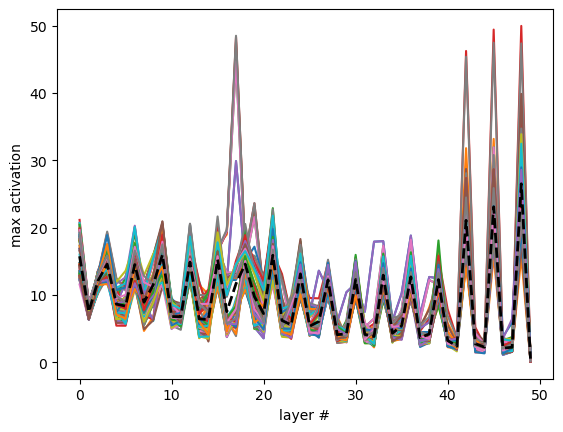

In [39]:
#1) pick an image
all_max_activations = []
for imi in range(dataset.shape[0]):
#2) for each layer, check max activation
    max_activations = np.array([outs[li][imi].max() for li in range(len(outs))])
    all_max_activations.append(max_activations)
    plt.plot(max_activations,label=imi)
mean_max_flows = np.mean(all_max_activations,axis=0)
std_max_flows = np.std(all_max_activations,axis=0)
plt.plot(mean_max_flows,'k--',lw=2)
#plt.legend()
plt.xlabel('layer #')
plt.ylabel('max activation')
plt.show()

#### imgnet

In [40]:
#REPEAT, for imgnet

import pickle
top_folder = 'imgnet/ilsvrc2012'


#random images from TEST SET 

sample_size = 88

with open('%s/test_preds_res50.p' % top_folder,'rb') as f:
    all_imfnames = list(pickle.load(f).keys())
np.random.seed(0)
imis = np.random.choice(range(len(all_imfnames)),sample_size,False)
imfnames = [all_imfnames[imi] for imi in imis]


orig_shp = input_shape #W, H
pad = (0,0) #i, j
imshape = (orig_shp[1]-2*pad[0], orig_shp[0]-2*pad[1])
assert K.image_data_format() == 'channels_last'
imgX = np.zeros((sample_size,imshape[0],imshape[1],3),dtype='float32')



for ii,imfname in enumerate(imfnames):
    
    fname = top_folder + '/' + imfname
    #print(fname)
    im = Image.open(fname)
    

    w, h = im.size
    if w < h:
        resize_shp = (imshape[0],h*imshape[0]//w)
        crop = (resize_shp[1]-imshape[1])//2
        imarray = np.array(
            im.resize(resize_shp,Image.Resampling.LANCZOS))[crop:crop+imshape[0]]
    else:
        resize_shp = (w*imshape[1]//h,imshape[1])
        crop = (resize_shp[0]-imshape[0])//2
        imarray = np.array(
            im.resize(resize_shp,Image.Resampling.LANCZOS))[:,crop:crop+imshape[1]]
    if imarray.ndim == 2:
        imarray = np.stack([imarray]*3,2)
    
    imgX[ii] = preprocess_input(imarray)[pad[0]:pad[0]+imshape[0],
                                                                pad[1]:pad[1]+imshape[1]]



In [41]:
dataset = imgX
outs = all_outs([dataset])
#pass data through network
for li in range(len(outs)):
    outs[li][outs[li] < 0] = 0
len(outs)
len(outs)

50

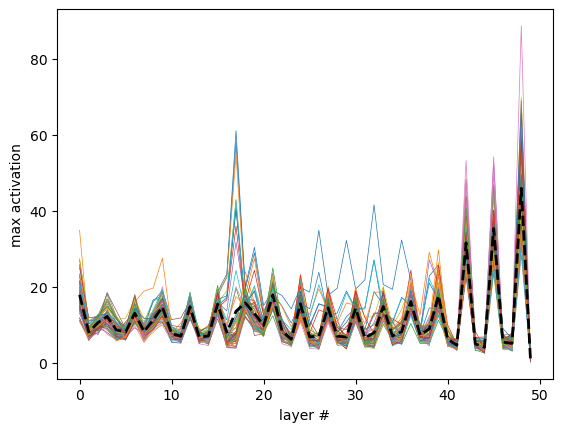

In [42]:
all_max_activations = []
#1) pick an image
for imi in range(dataset.shape[0]):
#2) for each layer, check max activation
    max_activations = np.array([outs[li][imi].max() for li in range(len(outs))])
    all_max_activations.append(max_activations)
    plt.plot(max_activations,label=imi,lw=.5)
mean_max_imgnet = np.mean(all_max_activations,axis=0)
std_max_imgnet = np.std(all_max_activations,axis=0)
plt.plot(mean_max_imgnet,'k--',lw=2)
#plt.legend()
plt.xlabel('layer #')
plt.ylabel('max activation')
plt.show()


#### comparison

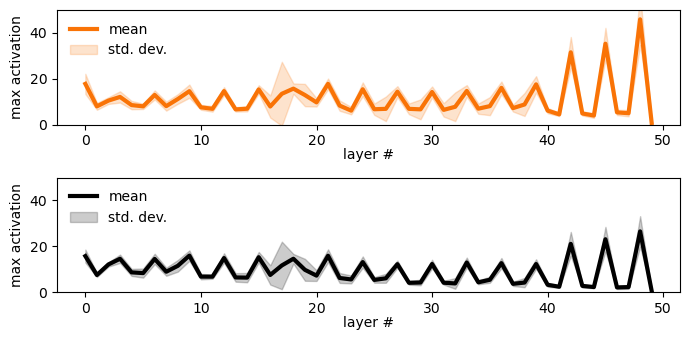

In [48]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

ylim = (0,50)
f,axes = plt.subplots(2,1,figsize=(7,3.5))
ax =axes[0]
x = range(len(mean_max_imgnet))
y = mean_max_imgnet
y_err = std_max_imgnet
c = 'xkcd:orange'
ax.plot(mean_max_imgnet,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0)

ax = axes[1]
x = range(len(mean_max_flows))
y = mean_max_flows
y_err = std_max_flows
c = 'xkcd:black'
ax.plot(mean_max_flows,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0,loc='upper left')
f.tight_layout()
# plt.savefig('activations_res50_fc.pdf', transparent=True)
plt.show()